In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


### parameters ###
L, T = 1, 0.1
dx = 0.001
c, CFL = 1, 0.2

N_x = int(L/dx)
x = np.linspace(-L/2, L/2, N_x)

dt = CFL * dx
N_t = int(T/dt)

### initial and periodic boundary condition ###
def initial_condition(x):
    width, height, center = 0.2, 1, 0.0
    u_initial = np.where(np.abs(x-center) <= width/2, height, 0)
    return u_initial

### The discretized flux ###
def F(u, dx, c=c):
    du_dx = np.zeros_like(u)
    du_dx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)

    du_dx[0] = (u[1] - u[-1]) / (2*dx)  # Forward difference for the first point
    du_dx[-1] = (u[0] - u[-2]) / (2*dx)  # Backward difference for the last point

    return -c * du_dx

### Create the animation and plot ###
def plot(x,utx, title, params, dt, save_anim=False, filename="burgers_solution"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, utx[0])

    line, = ax.plot(x, utx[0])
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title(title)
    ax.set_ylim(-0.5, 1.5)  # Set y-axis limits based on expected solution range

    def update(frame):
        line.set_ydata(utx[frame])
        ax.set_title(f"{title} (t = {frame * dt:.4f})\n{params}")
        return line,

    anim = animation.FuncAnimation(fig, update, frames=len(utx), interval=100, blit=True)

    # Save the animation (optional)
    if save_anim:
        anim.save(f'{filename}.gif', writer='pillow')

    ax.plot(x, utx[-1])
    plt.show()


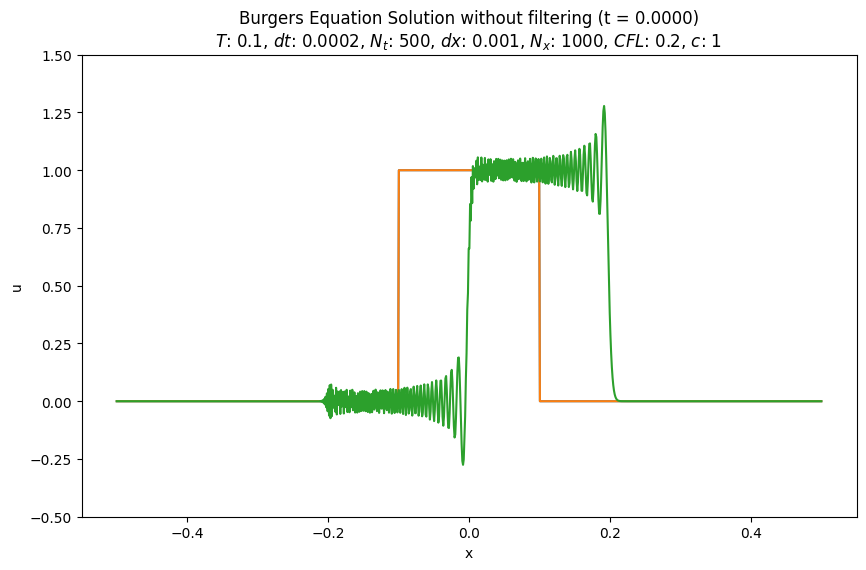

In [26]:
### RK4 ###
def RK4(u, dx, dt):
    k1 = F(u, dx)
    k2 = F(u + 0.5 * dt * k1, dx)
    k3 = F(u + 0.5 * dt * k2, dx)
    k4 = F(u + dt * k3, dx)
    return u + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

### Burgers equation: du/dt = -c * du/dx = F(u, dx, c) ###
def solve_Burgers(u_initial, dx, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4(utx[-1], dx, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers(u_initial, dx, dt, N_t)

title = "Burgers Equation Solution without filtering"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=False, filename="burgers_solution_without_filtering")


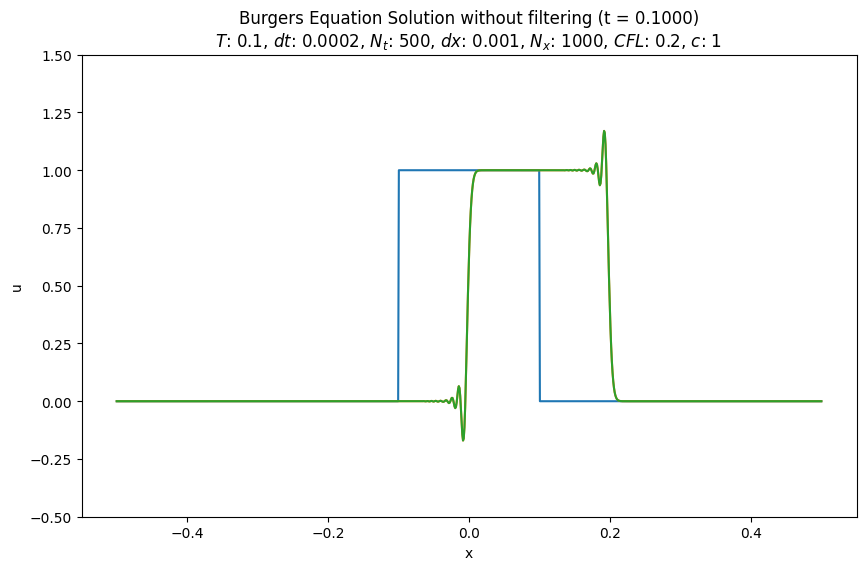

In [ ]:
# next point np.roll(u, -1)
# previous point np.roll(u, 1)

from numpy import roll 

def filter_flux(u, dx, dt):
    up1, up2, up3, up4 = roll(u, -1), roll(u, -2), roll(u, -3), roll(u, -4)
    um1, um2, um3, um4 = roll(u, 1), roll(u, 2), roll(u, 3), roll(u, 4)

    max_g, min_g = max(u), min(u)
    max_l = np.max([up2,up1,u,um1,um2],axis=0)
    min_l = np.min([up2,up1,u,um1,um2],axis=0)

    Ru = ( 4*(up1+um1) - (up2+um2) )/6.0

    ce,cs = 2000,0.1
    D = cs*(max_g-min_g) + (1-cs)*(max_l-min_l)+1e-6
    e = abs(Ru - u)/D 
    ep1 = roll(e,-1)
    e = np.max([e,ep1],axis=0)
    w = 1-np.exp(-ce*e**2)

    f8 = (35*(up1-u)-21*(up2-um1)+7*(up3-um2)-(up4-um3))/(4**4) # eq. 2
    f2 = (up1-u)/4
    f = w*f2 + (1-w)*f8
    fm1 = roll(f,+1)
    Fu = u + dt/dx*(f - fm1) # eq. 1
    return Fu

def solve_Burgers_with_filter(u_initial, dx, dt, N_t):
    utx = [u_initial.copy()]
    for _ in range(N_t):
        u = RK4(utx[-1], dx, dt)
        u = filter_flux(u, dx, dt)
        utx.append(u.copy())
    return utx

### main ###
u_initial = initial_condition(x)
utx = solve_Burgers_with_filter(u_initial, dx, dt, N_t)

title = "Burgers Equation Solution without filtering"
params = f"$T$: {T}, $dt$: {dt}, $N_t$: {N_t}, $dx$: {dx}, $N_x$: {N_x}, $CFL$: {CFL}, $c$: {c}"
plot(x, utx, title, params, dt, save_anim=True, filename="burgers_solution_with_filtering")
